# Preamble

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/src')
sys.path

['/home/src',
 '/home/notebooks',
 '/usr/local/lib/python37.zip',
 '/usr/local/lib/python3.7',
 '/usr/local/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/site-packages',
 '/usr/local/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython']

In [90]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

from statistical_tests import two_tailed_t_test
from simulations import simulate_normal, simulate_normal_array

## Validation

In [4]:
test = simulate_normal_array(np.ones(100000), 3*np.ones(100000), 10)
test.mean(axis=0), test.std(axis=0)

(array([1.00875514, 0.9985131 , 1.00932294, 0.99804928, 0.99669874,
        1.00061398, 1.00142393, 1.00574429, 0.98925955, 0.97943557]),
 array([2.9981791 , 2.99485181, 3.00240961, 2.99978615, 2.99283563,
        3.00656669, 3.00357645, 3.00572617, 3.00027284, 3.00207964]))

# Power vs Effect Size

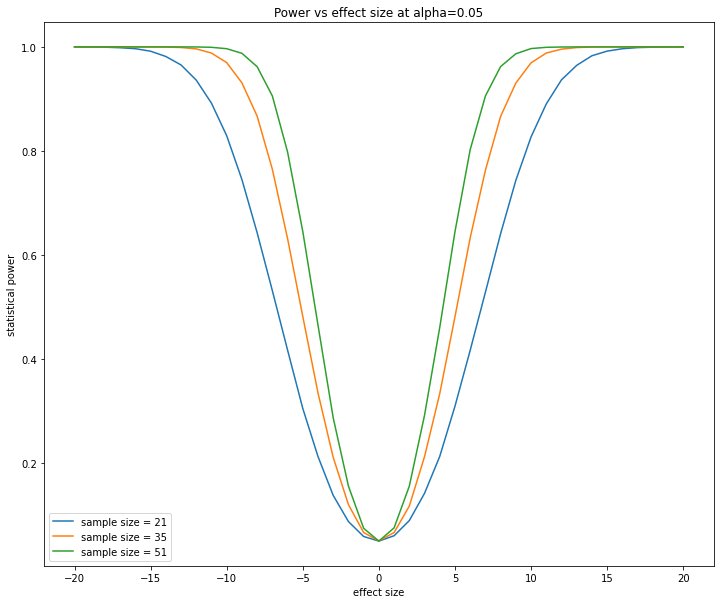

In [5]:
# Parameters:
sample_std = 15 # std deviation within our sample
number_simulations = 100000
H0 = 100.
alpha_level = 0.05

effect_sizes = np.linspace(-20, 20, 41)
fig, ax = plt.subplots(1,1,figsize=(12,10))

for sample_size in [21, 35, 51]:
    powers = []
    for effect_size in effect_sizes:
        # Generate samples
        sample_mean = H0 + effect_size
        samples = simulate_normal(sample_mean, sample_std, sample_size, number_simulations)
        # Calculate the p-values for each sample
        t_values, p_values = two_tailed_t_test(samples, H0)
        # Calculate the power
        power = (p_values <= alpha_level).sum() / number_simulations
        powers.append(power)

    # Plot the results
    ax.plot(effect_sizes, powers, label=f'sample size = {sample_size}')
ax.set_ylabel('statistical power')
ax.set_xlabel('effect size')
ax.set_title(f'Power vs effect size at alpha={alpha_level}');
plt.legend();

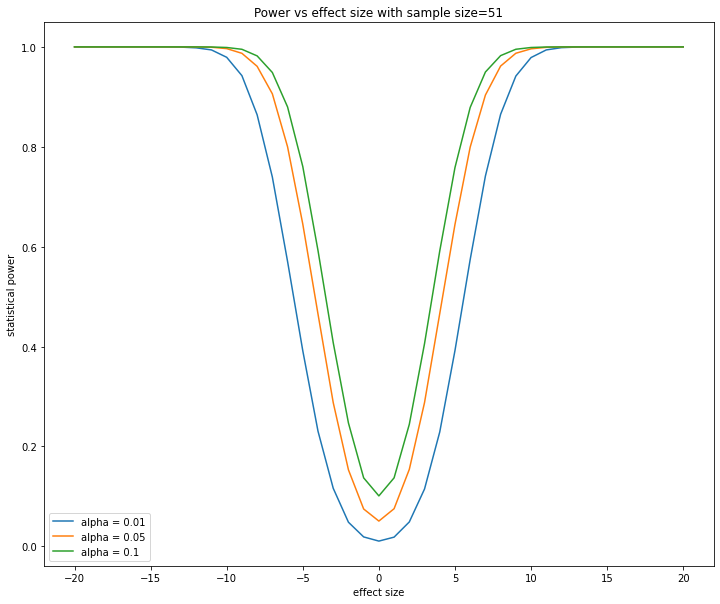

In [6]:
# Parameters:
sample_std = 15 # std deviation within our sample
sample_size = 51
number_simulations = 100000
H0 = 100.

effect_sizes = np.linspace(-20, 20, 41)
fig, ax = plt.subplots(1,1,figsize=(12,10))

for alpha_level in [0.01, 0.05, 0.1]:
    powers = []
    for effect_size in effect_sizes:
        # Generate samples
        sample_mean = H0 + effect_size
        samples = simulate_normal(sample_mean, sample_std, sample_size, number_simulations)
        # Calculate the p-values for each sample
        t_values, p_values = two_tailed_t_test(samples, H0)
        # Calculate the power
        power = (p_values <= alpha_level).sum() / number_simulations
        powers.append(power)

    # Plot the results
    ax.plot(effect_sizes, powers, label=f'alpha = {alpha_level}')
ax.set_ylabel('statistical power')
ax.set_xlabel('effect size')
ax.set_title(f'Power vs effect size with sample size={sample_size}');
plt.legend();

# Repeated t-test over time

Let's see what happens when we repeatedly apply a t-test on a time-series to see if the data-generating process drifted

(1000, 100000)

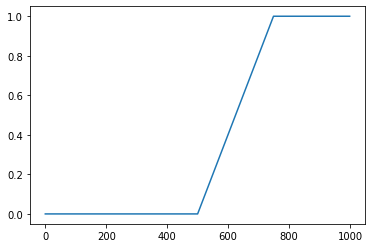

In [81]:
mean = np.zeros(1000)
mean[500:] = np.ones(500)
std = np.ones(1000)
mean[500:750] = np.linspace(0.0, 1.0, 250)
plt.plot(mean)

samples = simulate_normal_array(mean, std, number_simulations=100000)
samples.shape

In [139]:
bins = np.linspace(0.0, 1.0, 21)

In [150]:
# calculate power over time
def power_over_time(lookback, LAST_INDEX):
    POWER = []
    for last_index in LAST_INDEX:
        t, p = two_tailed_t_test(samples[last_index-lookback:last_index], H0=0.0)
        binned = np.digitize(p, bins)
        POWER.append(np.sum(np.digitize(p, bins)==1) / len(binned))
    return pd.DataFrame({'last_index': LAST_INDEX, f'power_{lookback}': POWER})

In [170]:
# Plot the power over time, for different lookback periods in the t-test
RES = []
for lookback in [10, 20, 50, 100, 250, 300]:
    RES.append(power_over_time(lookback=lookback, LAST_INDEX=range(400, 825, 25)).set_index('last_index'))

Text(0.5, 0, 'lookback')

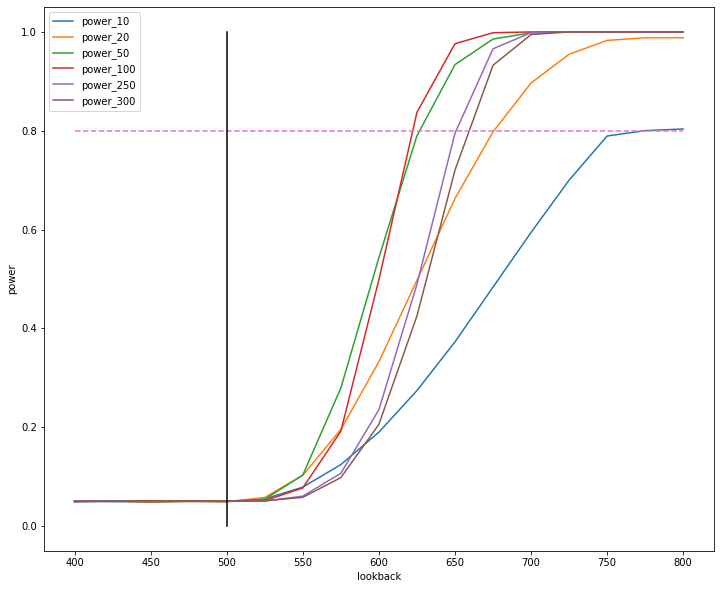

In [174]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12,10))
results = RES[0]
for res in RES[1:]:
    results = results.join(res)
results.plot(ax=ax)
ax.plot([400, 800], [0.8, 0.8], '--')
ax.plot([500, 500], [0.0, 1.0], 'k')
ax.set_ylabel('power')
ax.set_xlabel('lookback')

## Look at the distribution of the p values at a certain point in time, across all simulations

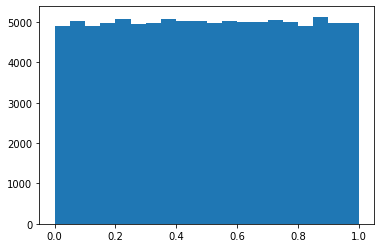

In [130]:
# Look at distribution of the p-test at the beginning
last_index = 200
t, p = two_tailed_t_test(samples[last_index-lookback:last_index], H0=0.0)
plt.hist(p, bins=20);

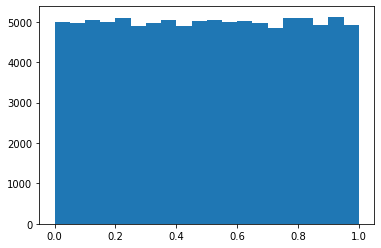

In [131]:
# Look at distribution of the p-test right before drift
last_index = 500
t, p = two_tailed_t_test(samples[last_index-lookback:last_index], H0=0.0)
plt.hist(p, bins=20);

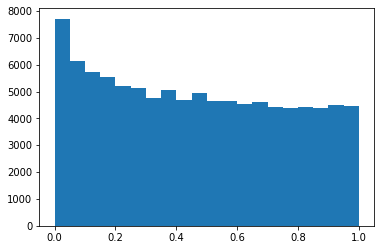

In [132]:
# Look at distribution of the p-test right after drift
last_index = 550
t, p = two_tailed_t_test(samples[last_index-lookback:last_index], H0=0.0)
bins, _, _ = plt.hist(p, bins=20)

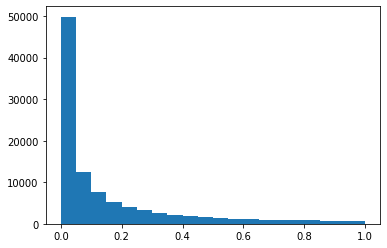

In [133]:
# Look at distribution of the p-test right after drift
last_index = 600
t, p = two_tailed_t_test(samples[last_index-lookback:last_index], H0=0.0)
bins, _, _ = plt.hist(p, bins=20)

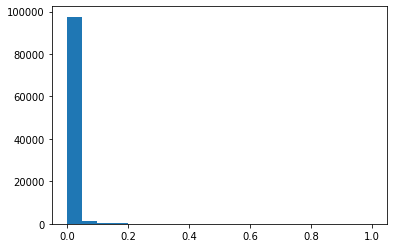

In [134]:
# Look at distribution of the p-test
last_index = 650
t, p = two_tailed_t_test(samples[last_index-lookback:last_index], H0=0.0)
bins, _, _ = plt.hist(p, bins=20)

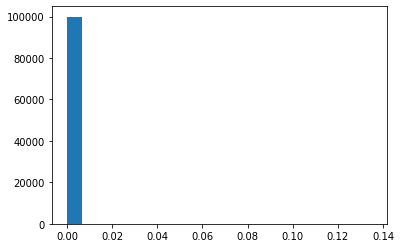

In [136]:
# Look at distribution of the p-test
last_index = 700
t, p = two_tailed_t_test(samples[last_index-lookback:last_index], H0=0.0)
bins, _, _ = plt.hist(p, bins=20)